# Vivarium Interface Demo

This notebook demonstrates the usage of the Vivarium Python API for building, verifying, and saving composite process-bigraph simulations. It includes examples of initializing a simulation, running it, retrieving results, and generating visual diagrams.

In [1]:
from vivarium import Vivarium
from vivarium.tests import DEMO_PROCESSES  # toy processes

In [2]:
# initialize a Vivarium object
v = Vivarium(processes=DEMO_PROCESSES)

In [3]:
# view the available types
v.get_types()

,Type
0,
1,mass
2,length^2*mass/time^3
3,mass/length^3
4,current*time/mass
...,...
90,length^4*mass/current*time^3
91,length^2*mass/current^2*time^3
92,mass/current*time^2
93,substance


In [4]:
# view the type schema for 'string'
v.get_type('string')

,Attribute,Value
0,_type,string
1,_default,
2,_check,check_string
3,_apply,replace
4,_serialize,serialize_string
5,_deserialize,deserialize_string
6,_dataclass,dataclass_string
7,_description,64-bit integer


In [5]:
# view the available processes
v.get_processes()

,Process
0,ram-emitter
1,console-emitter
2,composite
3,increase float


In [6]:
# inspect the config schema for the 'increase' process
v.process_schema('increase float')

'(rate:float)'

In [7]:
# inspect the process interface (inputs/outputs) for the 'increase' process
v.process_interface('increase float')

,,_type,_default,Type
Inputs,amount,float,1.0,NaN
Outputs,amount,NaN,NaN,float


In [8]:
# add an increase process called 'increase process'
v.add_process(name='increase',
              process_id='increase float',  # this is the process id
              config={'rate': 0.1},         # set according to the config schema
              )

# print the current state
v

Vivarium( 
{ 'global_time': 0.0,
  'increase': { 'address': 'local:increase float',
                'config': {'rate': 0.1},
                'inputs': {},
                'instance': <vivarium.tests.IncreaseFloat object at 0x113522fd0>,
                'interval': 1.0,
                'outputs': {}}})

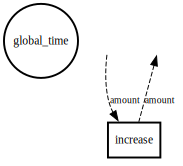

In [9]:
# display as a diagram
v.diagram(dpi='70')

In [10]:
# connect the 'increase' process to the state through its inputs and outputs
v.connect_process(
    process_name='increase',
    inputs={'amount': ['top', 'A']},
    outputs={'amount': ['top', 'A']}
)

# display the current state
v

Vivarium( 
{ 'global_time': 0.0,
  'increase': { 'address': 'local:increase float',
                'config': {'rate': 0.1},
                'inputs': {'amount': ['top', 'A']},
                'instance': <vivarium.tests.IncreaseFloat object at 0x113522fd0>,
                'interval': 1.0,
                'outputs': {'amount': ['top', 'A']}},
  'top': {'A': 1.0}})

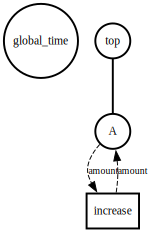

In [11]:
# display the current state as a diagram
v.diagram(dpi='70')

In [12]:
# get the value of 'top.A'
v.get_value(path=['top', 'A'])

1.0

In [13]:
# set value of 'top.A' to 100
v.set_value(path=['top', 'A'], value=100.0)
v.get_value(path=['top', 'A'])

100.0

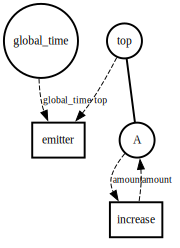

In [14]:
# add an emitter to save the history
v.add_emitter()

# display the current state
v.diagram(dpi='70')

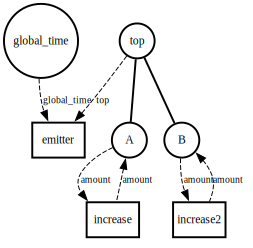

In [15]:
# add more objects
v.add_object(name='B', path=['top'], value=1)

# add another increase process
v.add_process(name='increase2',
              process_id='increase float',
              config={'rate': -0.1},
              inputs={'amount': ['top', 'B']},
              outputs={'amount': ['top', 'B']}
              )

# display the current state
v.diagram(dpi='70', size='30,15')

In [16]:
# run the simulation for 10 time units
v.run(interval=10)

In [17]:
# get the timeseries results
timeseries = v.get_timeseries(significant_digits=6)
timeseries

{'global_time': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
 'top.A': [100.0,
  110.0,
  121.0,
  133.1,
  146.41,
  161.051,
  177.1561,
  194.87171,
  214.358881,
  235.794769,
  259.374246],
 'top.B': [1.0,
  0.9,
  0.81,
  0.729,
  0.6561,
  0.59049,
  0.531441,
  0.478297,
  0.430467,
  0.38742,
  0.348678]}

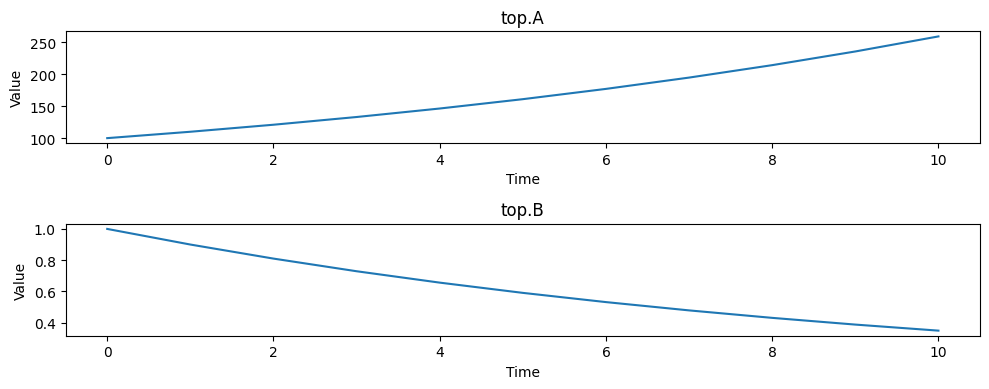

In [18]:
v.plot_timeseries(
    query=None,
    subplot_size=(10, 2),
    # ncols=1,
    # combined_vars=None
)

# Save and Load

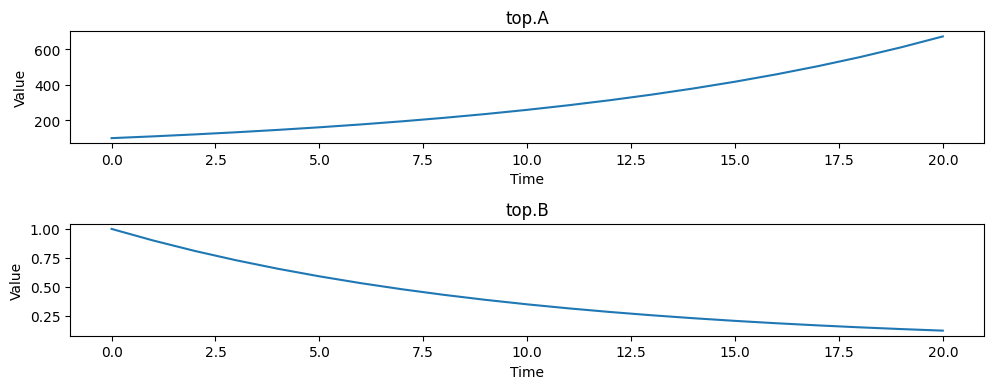

In [19]:
# run the simulation for 10 time units
# v.set_value(path=['global_time'], value=0)
v.run(interval=10)
v.plot_timeseries(query=['top.A', 'top.B'], subplot_size=(10, 2),)

In [20]:
# save the current state to a file
v.save(filename='demo1')

Saved file: out/demo1.json


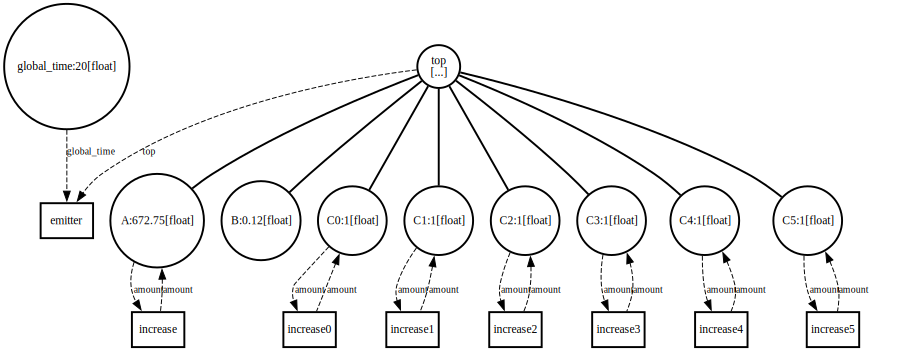

In [21]:
import random

n_new_nodes = 6

# make a new Vivarium object (v2) from the saved file
v2 = Vivarium(document='out/demo1.json', processes=DEMO_PROCESSES)

# add another object and process
for i in range(n_new_nodes):
    v2.add_object(name=f'C{i}', path=['top'], value=1)
    v2.add_process(name=f'increase{i}',
                   process_id='increase float',
                   config={'rate': random.uniform(-1, 1)},
                   inputs={'amount': ['top', f'C{i}']},
                   outputs={'amount': ['top', f'C{i}']}
                   )

# display the current state as a diagram
v2.diagram(dpi='70',
           show_values=True,
           show_types=True,
           )

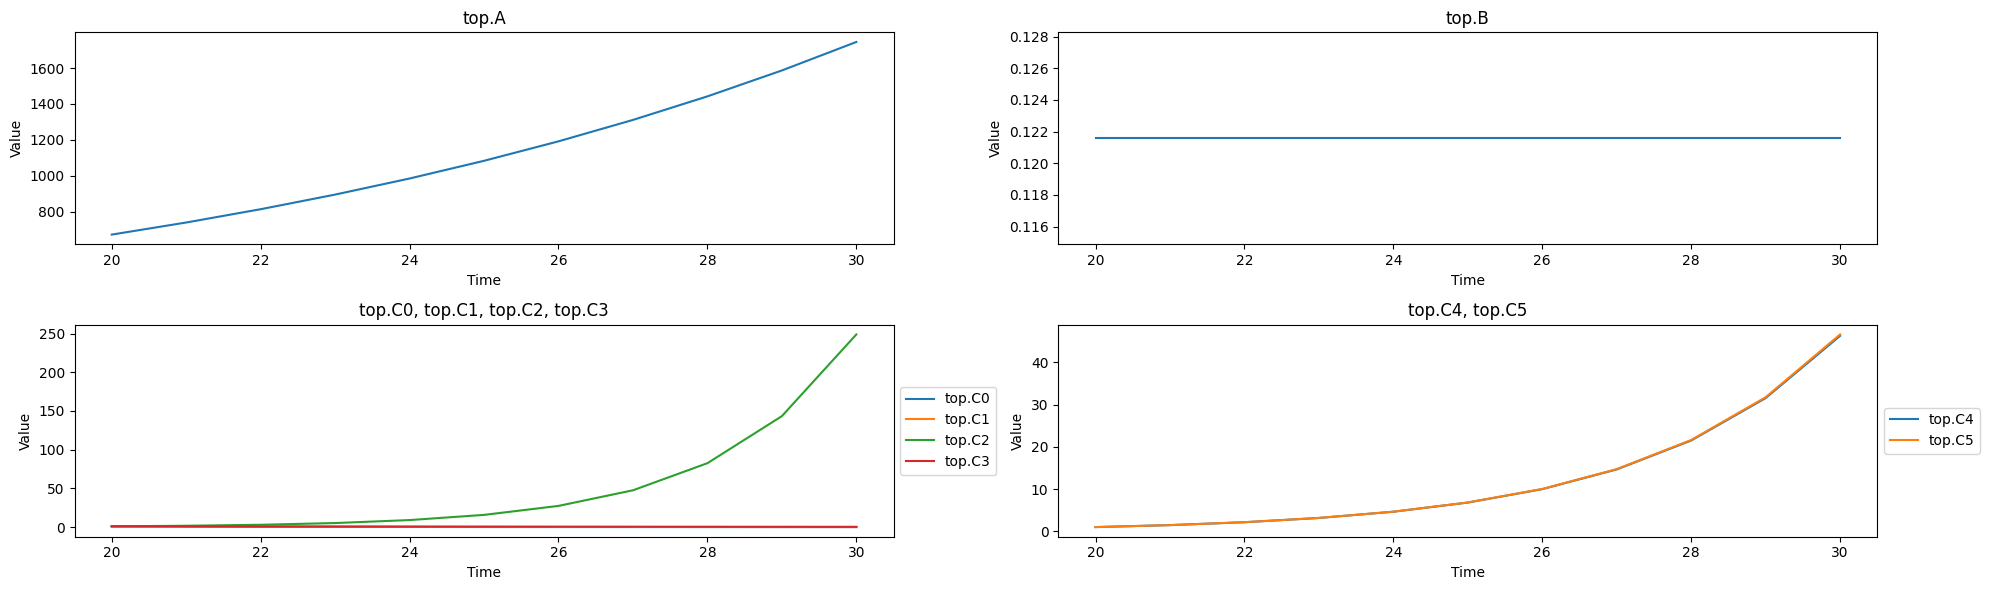

In [22]:
v2.run(interval=10)
v2.plot_timeseries(subplot_size=(10, 3),
                   ncols=2,
                   combined_vars=[[f'top.C{i}' for i in range(4)],
                                  [f'top.C{i}' for i in range(4, n_new_nodes)]])

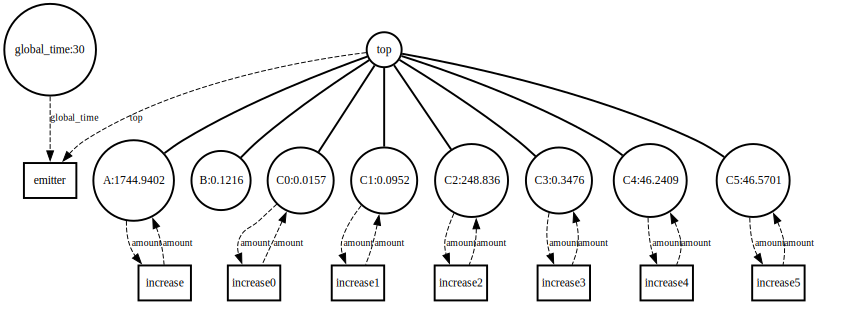

In [23]:
v2.diagram(dpi='70',
           show_values=True,
           # show_types=True,
           significant_digits=4,
           )

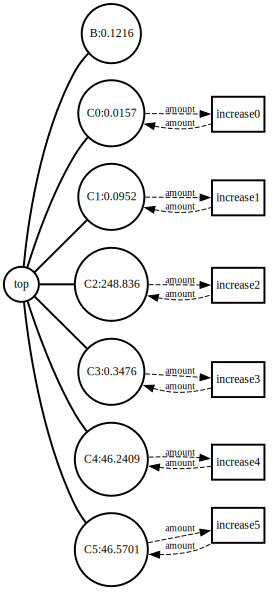

In [29]:
v2.diagram(dpi='70',
           show_values=True,
           # show_types=True,
           significant_digits=4,
           rankdir='LR',
           remove_nodes=['top.A', 'increase', 'emitter', 'global_time'],
           )